# TODO

- bring in exogenous factors: legislative production, 
-    mapping legal act directory codes - case law directory codes
- bring in exogenous factors: lodgment in year, year-1, year-2,...
- lodgment-judgment-gap; use lodgment-data rather than judgment-data? go for judgment date directly?
- how to deal with ambiguities in dircodes?
- verlängern der timeline? 
- trends auf zweiter dircode ebene

X implement arima model

X implement ols

x missings that are actual 0s

In [54]:
# packages and preferences
import pyreadr
import numpy as np 
import pandas as pd
import re 
from itertools import chain # flatten lists

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression

# gof
from sklearn.metrics import mean_squared_error, r2_score

import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('display.max_rows', None)
#pd.set_option('display.max_columns', None)

In [28]:
tmp = pyreadr.read_r("/Users/david/Documents/david/karriere/projects/predict precedential value/data/data_for_ml_training.RData") 
df = tmp["art267_judgments_62_23"] # look up name of pandas df using print(tmp.keys())

df = df.loc[df["directorycodes"] != "no info",]
print(df.isna().sum())
print(df.shape)

celex             0
title             0
date_lodgment     0
date_judgment     0
countrycheck      0
languages         0
formtype          0
directorycodes    0
subjectmatter     0
procedure         0
ag                0
jr                0
applicant         0
defendant         0
observations      0
affected          0
cited             0
textlength        0
costs             0
textout           0
textrawout        0
year_judgment     0
dtype: int64
(8099, 22)


In [29]:
# after-Lisbon coding scheme of first dircodes in each row of column 

df["directorycodes_lower"] = df["directorycodes"].str.lower()
df['substring_column'] = df['directorycodes_lower'].str.slice(0, 4)
df['DoCL_after_Lisbon'] = df['substring_column'].str.contains(r'\d\.\d{2}', regex=True).astype(int)
print(df['DoCL_after_Lisbon'].value_counts().sort_index())
df = df.loc[df['DoCL_after_Lisbon'] == 1,]

DoCL_after_Lisbon
0    4271
1    3828
Name: count, dtype: int64


/var/folders/3p/ynx9h1ws7mqfb01ljsgzgs600000gn/T/ipykernel_1023/3061250802.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["directorycodes_lower"] = df["directorycodes"].str.lower()
/var/folders/3p/ynx9h1ws7mqfb01ljsgzgs600000gn/T/ipykernel_1023/3061250802.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['substring_column'] = df['directorycodes_lower'].str.slice(0, 4)
/var/folders/3p/ynx9h1ws7mqfb01ljsgzgs600000gn/T/ipykernel_1023/3061250802.py:5: SettingWithCopyWarning: 
A value is trying to b

In [32]:
list_dircodes_aL = df.loc[df['DoCL_after_Lisbon'] == 1, 'directorycodes_lower'].str.split("@")

#pattern_to_match = re.compile(r"[a-z]-\d\d|\d\.\d\d") # window size=4
pattern_to_match = re.compile(r"[a-z]-|\d\.") # window size=2

window_size = 2 # Level 1 only ("A- ...", "1. ...")

list_dircodes_aL_num = [
    list(sorted(set([item[0:window_size] for item in sublist if pattern_to_match.match(item[0:window_size])])))
    for sublist in list_dircodes_aL
]

list_dircodes_flat = list(chain(*list_dircodes_aL_num))
#print(len(flattened_list))
print(len(sorted(set(list_dircodes_flat))))
# 1311 -> 152
#print(sorted(set(flattened_list)))

pattern = re.compile("[a-z]-\d{2}")
filtered_list = [s for s in list_dircodes_flat if pattern.match(s)]
print(len(set(filtered_list)))
# 675 -> 97

pattern = re.compile("\d.\d{2}")
filtered_list = [s for s in list_dircodes_flat if pattern.match(s[0:window_size])]
print(len(set(filtered_list)))
# 636 -> 55

8
0
0


In [33]:
df.loc[df["celex"] == "62014CJ0049", 'date_lodgment'] = '02/03/2014'
df["year_lodgment"] = df["date_lodgment"].str.slice(6,10).astype(int)
df["year_lodgment"].value_counts()

df["year_judgment"] = df["year_judgment"].astype(int)
df["year_judgment"].value_counts().sort_index()



year_judgment
2010    237
2011    235
2012    249
2013    276
2014    295
2015    296
2016    301
2017    325
2018    354
2019    225
2020    173
2021    226
2022    359
2023    277
Name: count, dtype: int64

In [36]:
# expand dircodes (one or more per judgment) and write each one into a new line, creating a new_df
new_df = pd.concat([pd.Series(sublist, name="dircode").astype(float) for sublist in list_dircodes_aL_num]
                   , keys=df["year_judgment"]).reset_index(level=0)
print(df.shape)
print(new_df.shape)
print(new_df)


(3828, 26)
(5456, 2)
   year_judgment  dircode
0           2010      4.0
0           2010      1.0
1           2010      4.0
0           2010      4.0
0           2010      4.0
0           2010      2.0
1           2010      4.0
0           2011      6.0
0           2011      6.0
0           2010      1.0
1           2010      4.0
0           2010      4.0
0           2010      4.0
0           2010      1.0
1           2010      4.0
0           2010      4.0
0           2010      1.0
0           2011      3.0
1           2011      4.0
0           2010      4.0
0           2010      4.0
0           2010      1.0
1           2010      3.0
0           2010      4.0
0           2010      1.0
0           2010      3.0
1           2010      4.0
0           2010      1.0
1           2010      4.0
0           2011      4.0
0           2010      4.0
0           2010      3.0
1           2010      4.0
0           2010      4.0
0           2010      4.0
0           2010      4.0
0           2011 

In [37]:
# frequency distribution by dircode and year
trend_df = new_df.groupby(['year_judgment', 'dircode']).size().reset_index(name='count')

# fill in missings (TODO this more generally: compare trend_df against reference dataset of years*dircodes filled with counts=0)
missing_data = {
    'year_judgment': [2010,2014,2015,2023,2013,2014,2019,2020,2021,2022,2010,2014,2016,2018,2019,2020],
    'dircode':         [ 7.0, 7.0, 7.0, 7.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0],
    'count':         [ 0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0]
    }

trend_df = pd.concat([trend_df, pd.DataFrame(missing_data)])

trend_df_sort = trend_df.sort_values(by=['dircode', 'year_judgment'])
trend_df_sort
trend_df_sort["dircode"] = trend_df_sort["dircode"].astype(str)
trend_df_sort.reset_index(drop=True, inplace=True)
print(trend_df_sort.shape)
trend_df_sort


(112, 3)


,year_judgment,dircode,count
0,2010,1.0,29
1,2011,1.0,28
2,2012,1.0,48
3,2013,1.0,59
4,2014,1.0,82
5,2015,1.0,74
6,2016,1.0,87
7,2017,1.0,62
8,2018,1.0,65
9,2019,1.0,48


In [38]:
# dv lags

trend_df_sort_ols = trend_df_sort
trend_df_sort_ols['count_l1'] = trend_df_sort_ols.groupby(['dircode'])['count'].shift()
trend_df_sort_ols['count_l2'] = trend_df_sort_ols.groupby(['dircode'])['count_l1'].shift()
trend_df_sort_ols['count_l3'] = trend_df_sort_ols.groupby(['dircode'])['count_l2'].shift()
trend_df_sort_ols['count_l4'] = trend_df_sort_ols.groupby(['dircode'])['count_l3'].shift()
trend_df_sort_ols['count_l5'] = trend_df_sort_ols.groupby(['dircode'])['count_l4'].shift()

trend_df_sort_ols


,year_judgment,dircode,count,count_l1,count_l2,count_l3,count_l4,count_l5
0,2010,1.0,29,NaN,NaN,NaN,NaN,NaN
1,2011,1.0,28,29.0,NaN,NaN,NaN,NaN
2,2012,1.0,48,28.0,29.0,NaN,NaN,NaN
3,2013,1.0,59,48.0,28.0,29.0,NaN,NaN
4,2014,1.0,82,59.0,48.0,28.0,29.0,NaN
5,2015,1.0,74,82.0,59.0,48.0,28.0,29.0
6,2016,1.0,87,74.0,82.0,59.0,48.0,28.0
7,2017,1.0,62,87.0,74.0,82.0,59.0,48.0
8,2018,1.0,65,62.0,87.0,74.0,82.0,59.0
9,2019,1.0,48,65.0,62.0,87.0,74.0,82.0


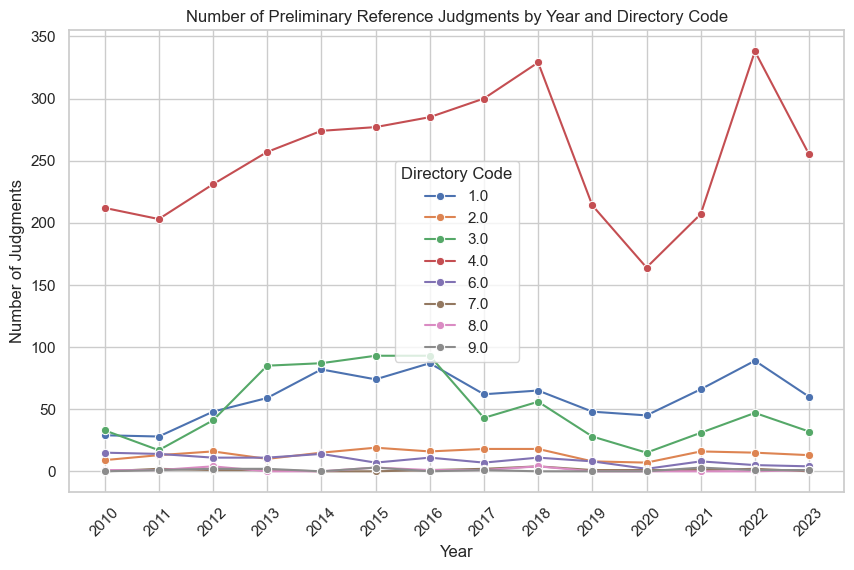

In [40]:
# plot trends by dircode

sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

# Plot trend lines
sns.lineplot(x='year_judgment', y='count', hue='dircode', data=trend_df_sort, marker='o')

plt.title('Number of Preliminary Reference Judgments by Year and Directory Code')
plt.xticks(trend_df_sort['year_judgment'].unique(), rotation=45)
plt.xlabel('Year')
plt.ylabel('Number of Judgments')
plt.legend(title='Directory Code')
plt.show()

In [41]:
# Exogenous variable - assuming 'group' is a categorical variable encoded as integers
exog_data = pd.get_dummies(trend_df_sort['dircode'], prefix='dircode', drop_first=True)
exog_data.index = trend_df_sort['year_judgment']
exog_data.index
time_series = trend_df_sort.set_index(['year_judgment','dircode'])['count'].astype(float)#
time_series
exog_data = exog_data.astype(int)

In [42]:
# limit timeframe
time_series_masked = time_series[time_series.index.get_level_values(0) <= 2020]
time_series_masked
time_series_masked.index

MultiIndex([(2010, '1.0'),
            (2011, '1.0'),
            (2012, '1.0'),
            (2013, '1.0'),
            (2014, '1.0'),
            (2015, '1.0'),
            (2016, '1.0'),
            (2017, '1.0'),
            (2018, '1.0'),
            (2019, '1.0'),
            (2020, '1.0'),
            (2010, '2.0'),
            (2011, '2.0'),
            (2012, '2.0'),
            (2013, '2.0'),
            (2014, '2.0'),
            (2015, '2.0'),
            (2016, '2.0'),
            (2017, '2.0'),
            (2018, '2.0'),
            (2019, '2.0'),
            (2020, '2.0'),
            (2010, '3.0'),
            (2011, '3.0'),
            (2012, '3.0'),
            (2013, '3.0'),
            (2014, '3.0'),
            (2015, '3.0'),
            (2016, '3.0'),
            (2017, '3.0'),
            (2018, '3.0'),
            (2019, '3.0'),
            (2020, '3.0'),
            (2010, '4.0'),
            (2011, '4.0'),
            (2012, '4.0'),
            (2013, '4.0'),
 

In [44]:
# Set ARIMA order
p = 5  # Autoregressive order
d = 0  # Integration order
q = 0  # Moving average order

time_series_masked_flat = time_series_masked.reset_index(level='dircode', drop=True)

# Fit SARIMAX model with exogenous variable
model = ARIMA(endog=time_series_masked_flat#, exog=exog_data
              , order=(p, d, q))
#model = SARIMAX(endog=time_series, exog=exog_data, order=(p, d, q))
results = model.fit()


print(results.summary())

                               SARIMAX Results                                
Dep. Variable:                  count   No. Observations:                   88
Model:                 ARIMA(5, 0, 0)   Log Likelihood                -425.280
Date:                Thu, 04 Jan 2024   AIC                            864.560
Time:                        07:28:19   BIC                            881.901
Sample:                             0   HQIC                           871.546
                                 - 88                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         48.3902     80.035      0.605      0.545    -108.475     205.255
ar.L1          0.9766      0.149      6.559      0.000       0.685       1.268
ar.L2          0.1714      0.238      0.721      0.4

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [46]:
forecast_steps = 10  # Number of steps to predict
forecast = results.get_forecast(steps=forecast_steps)

forecast.predicted_mean
# Extract predicted values
#predicted_values = forecast.predicted_mean
#predicted_values = pd.DataFrame({'predicted': forecast.predicted_mean}, index=time_series_masked.index[-3:])
#predicted_values

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


88     5.171355
89    10.510273
90    16.511752
91    22.414016
92    27.326843
93    31.626127
94    35.064708
95    37.809340
96    40.009637
97    41.722626
Name: predicted_mean, dtype: float64

In [52]:
# for OLS 

cutoff_year = 2020
trend_df_sort_ols_train = trend_df_sort_ols.loc[
    #(trend_df_sort_ols["year_judgment"] >= 2013) & 
    (trend_df_sort_ols["year_judgment"] <= cutoff_year)]

trend_df_sort_ols_pred = trend_df_sort_ols.loc[
    (trend_df_sort_ols["year_judgment"] > cutoff_year)]


trend_df_sort_ols_train.dropna(inplace=True)
trend_df_sort_ols_train



/var/folders/3p/ynx9h1ws7mqfb01ljsgzgs600000gn/T/ipykernel_1023/2471506916.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trend_df_sort_ols_train.dropna(inplace=True)


,year_judgment,dircode,count,count_l1,count_l2,count_l3,count_l4,count_l5
5,2015,1.0,74,82.0,59.0,48.0,28.0,29.0
6,2016,1.0,87,74.0,82.0,59.0,48.0,28.0
7,2017,1.0,62,87.0,74.0,82.0,59.0,48.0
8,2018,1.0,65,62.0,87.0,74.0,82.0,59.0
9,2019,1.0,48,65.0,62.0,87.0,74.0,82.0
10,2020,1.0,45,48.0,65.0,62.0,87.0,74.0
19,2015,2.0,19,15.0,10.0,16.0,13.0,9.0
20,2016,2.0,16,19.0,15.0,10.0,16.0,13.0
21,2017,2.0,18,16.0,19.0,15.0,10.0,16.0
22,2018,2.0,18,18.0,16.0,19.0,15.0,10.0


In [56]:
lm = LinearRegression()

# Train the model using the training sets

lm.fit(trend_df_sort_ols_train[['year_judgment'
                                , 'dircode'
                                , "count_l1"
                                , "count_l2"
                                , "count_l3"
                                , "count_l4"
                                , "count_l5"]]
       , trend_df_sort_ols_train['count'])

print("Coefficients: \n", lm.coef_)

# gof

preds_train = lm.predict(trend_df_sort_ols_train[['year_judgment'
                                , 'dircode'
                                , "count_l1"
                                , "count_l2"
                                , "count_l3"
                                , "count_l4"
                                , "count_l5"]])

print("Mean squared error: %.2f" % mean_squared_error(trend_df_sort_ols_train['count'], preds_train))
print("Coefficient of determination: %.2f" % r2_score(trend_df_sort_ols_train['count'], preds_train))

#lm2 = sm.OLS(trend_df_sort_ols_train['count']
#             , sm.add_constant(trend_df_sort_ols_train[['year_judgment'
#                                                        , 'dircode'
#                                                        , "count_l1"
#                                , "count_l2"
#                                , "count_l3"
#                                , "count_l4"
#                                , "count_l5"]])).fit()
#lm2.summary()



Coefficients: 
 [-2.77337008  0.36714068  0.91806721  0.16873025 -0.08935466  0.03460758
 -0.12525848]
Mean squared error: 354.40
Coefficient of determination: 0.95


In [61]:
# predictions
trend_df_sort_ols_pred

# TODO: cannot use lagged counts since these are observed, while prediction would be based on estimation: 
# for 2022, cannot use count_l1
# for 2023, cannot use count_l1, count_l2
# would need to make predictions one at a time: predict 2021, then use that estimate to predict next year, and so on

# THIS IS WRONG:
preds_pred = lm.predict(trend_df_sort_ols_pred[['year_judgment'
                                , 'dircode'
                                , "count_l1"
                                , "count_l2"
                                , "count_l3"
                                , "count_l4"
                                , "count_l5"]])

pd.concat([trend_df_sort_ols_pred, pd.Series(preds_pred)],axis=1)


,year_judgment,dircode,count,count_l1,count_l2,count_l3,count_l4,count_l5,0
11,2021.0,1.0,66.0,45.0,48.0,65.0,62.0,87.0,280.108752
12,2022.0,1.0,89.0,66.0,45.0,48.0,65.0,62.0,-9.318439
13,2023.0,1.0,60.0,89.0,66.0,45.0,48.0,65.0,-6.688259
25,2021.0,2.0,16.0,7.0,8.0,18.0,18.0,16.0,NaN
26,2022.0,2.0,15.0,16.0,7.0,8.0,18.0,18.0,NaN
27,2023.0,2.0,13.0,15.0,16.0,7.0,8.0,18.0,NaN
39,2021.0,3.0,31.0,15.0,28.0,56.0,43.0,93.0,NaN
40,2022.0,3.0,47.0,31.0,15.0,28.0,56.0,43.0,NaN
41,2023.0,3.0,32.0,47.0,31.0,15.0,28.0,56.0,NaN
53,2021.0,4.0,207.0,164.0,214.0,329.0,300.0,285.0,NaN
